-------- > epoch 1:  coût moyen entraînement = 0.8449174761772156
-------- > epoch 1:  taux moyen entraînement = 0.7176594734191895
-------- > epoch 1:  coût moyen validation = 0.5934909582138062
-------- > epoch 1:  taux moyen validation = 0.7983000874519348
-------- > epoch 2:  coût moyen entraînement = 0.5394740700721741
-------- > epoch 2:  taux moyen entraînement = 0.8118993043899536
-------- > epoch 2:  coût moyen validation = 0.5496941804885864
-------- > epoch 2:  taux moyen validation = 0.8027001023292542
-------- > epoch 3:  coût moyen entraînement = 0.49019864201545715
-------- > epoch 3:  taux moyen entraînement = 0.8304595351219177
-------- > epoch 3:  coût moyen validation = 0.48120373487472534
-------- > epoch 3:  taux moyen validation = 0.8327999711036682
-------- > epoch 4:  coût moyen entraînement = 0.4623768627643585
-------- > epoch 4:  taux moyen entraînement = 0.8386598825454712
-------- > epoch 4:  coût moyen validation = 0.45436951518058777
-------- > epoch 4:  

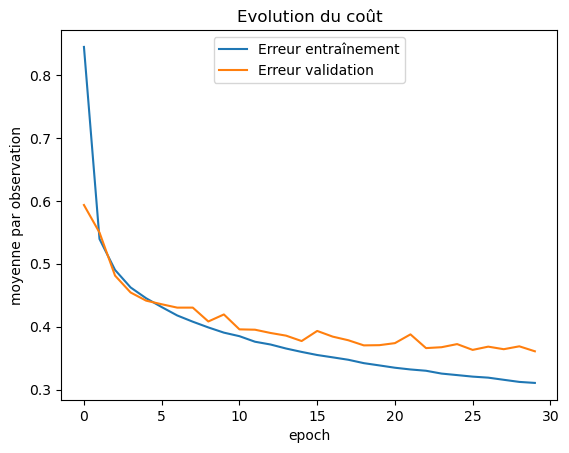

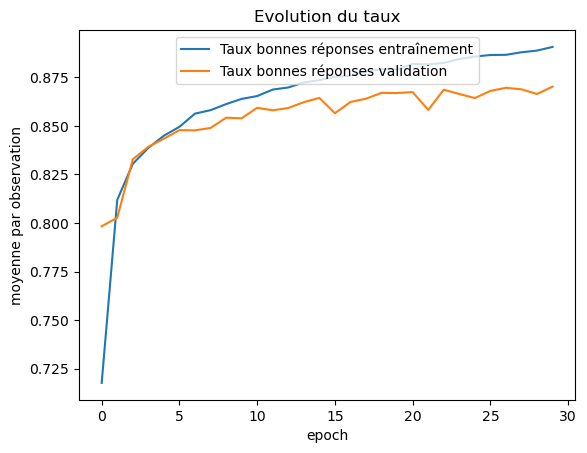

In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Exemple simple de MNIST avec PyTorch
Exemple avec nn.Sequential et F.cross_entropy
Production de métriques avec graphes
Fonction entrainer
"""
import torch
torch.manual_seed(0) # Pour résultats reproductibles

# Fonction J d'entropie croisée
import torch.nn.functional as F
fonction_cout = F.cross_entropy

def taux_bonnes_predictions(lot_Y_predictions, lot_Y):
    predictions_categorie = torch.argmax(lot_Y_predictions, dim=1)
    return (predictions_categorie == lot_Y).float().mean()

from torch import nn
# Définition de l'architecture du RNA
modele = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
)
    
from torch import optim
optimiseur = optim.SGD(modele.parameters(), lr=0.05)

import torchvision
import torchvision.transforms as transforms

#Chargement des données
ds = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
ds_ent, ds_valid = torch.utils.data.random_split(ds, [50000, 10000])
ds_test = torchvision.datasets.MNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())
ds_test = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())

#Création du DataLoader avec le dataset
dl_ent = torch.utils.data.DataLoader(ds_ent, batch_size=100, shuffle = True)
dl_valid = torch.utils.data.DataLoader(ds_valid, batch_size=100)

def entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10):

    # Listes pour les métriques par epoch
    liste_cout_moyen_ent = []
    liste_taux_moyen_ent = []
    liste_cout_moyen_valid = []
    liste_taux_moyen_valid = []
    
    # Boucle d'apprentissage
    for epoch in range(nb_epochs):
        cout_total_ent = 0 # pour cumuler les couts par mini-lot
        taux_bonnes_predictions_ent = 0 # pour cumuler les taux par mini-lot
        modele.train() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        
        # Boucle d'apprentissage par mini-lot pour une epoch
        for lot_X, lot_Y in dl_ent:
            optimiseur.zero_grad() # Remettre les dérivées à zéro
            lot_Y_predictions = modele(lot_X) # Appel de la méthode forward
            cout = fonction_cout(lot_Y_predictions, lot_Y)
            cout.backward() # Calcul des gradiants par rétropropagation
            with torch.no_grad():
                cout_total_ent +=cout
                taux_bonnes_predictions_ent += taux_bonnes_predictions(lot_Y_predictions, lot_Y)
            optimiseur.step() # Mise à jour des paramètres
        # Calculer les moyennes par mini-lot
        with torch.no_grad():
            cout_moyen_ent = cout_total_ent/len(dl_ent)
            taux_moyen_ent = taux_bonnes_predictions_ent/len(dl_ent)
       
        modele.eval() # Pour certains types de couches (nn.BatchNorm2d, nn.Dropout, ...)
        with torch.no_grad():
            cout_valid = sum(fonction_cout(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
            taux_bons_valid = sum(taux_bonnes_predictions(modele(lot_valid_X), lot_valid_Y) for lot_valid_X, lot_valid_Y in dl_valid)
        cout_moyen_valid = cout_valid/len(dl_valid)
        taux_moyen_valid = taux_bons_valid/len(dl_valid)
        print(f'-------- > epoch {epoch+1}:  coût moyen entraînement = {cout_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  taux moyen entraînement = {taux_moyen_ent}')
        print(f'-------- > epoch {epoch+1}:  coût moyen validation = {cout_moyen_valid}')
        print(f'-------- > epoch {epoch+1}:  taux moyen validation = {taux_moyen_valid}')
    
        liste_cout_moyen_ent.append(cout_moyen_ent)
        liste_taux_moyen_ent.append(taux_moyen_ent)
        liste_cout_moyen_valid.append(cout_moyen_valid)
        liste_taux_moyen_valid.append(taux_moyen_valid)
    
    # Affichage du graphique d'évolution des métriques par epoch
    import numpy as np
    import matplotlib.pyplot as plt
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_ent,label='Erreur entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_cout_moyen_valid,label='Erreur validation')
    plt.title("Evolution du coût")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()
        
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_ent,label='Taux bonnes réponses entraînement')
    plt.plot(np.arange(0,nb_epochs),liste_taux_moyen_valid,label='Taux bonnes réponses validation')
    plt.title("Evolution du taux")
    plt.xlabel('epoch')
    plt.ylabel('moyenne par observation')
    plt.legend(loc='upper center')
    plt.show()

entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=30)

-------- > epoch 1:  coût moyen entraînement = 0.3070470988750458
-------- > epoch 1:  taux moyen entraînement = 0.8901407718658447
-------- > epoch 1:  coût moyen validation = 0.37295714020729065
-------- > epoch 1:  taux moyen validation = 0.8654998540878296
-------- > epoch 2:  coût moyen entraînement = 0.3053663671016693
-------- > epoch 2:  taux moyen entraînement = 0.8906404376029968
-------- > epoch 2:  coût moyen validation = 0.3622247576713562
-------- > epoch 2:  taux moyen validation = 0.8711998462677002
-------- > epoch 3:  coût moyen entraînement = 0.3036971390247345
-------- > epoch 3:  taux moyen entraînement = 0.8909806609153748
-------- > epoch 3:  coût moyen validation = 0.3567965626716614
-------- > epoch 3:  taux moyen validation = 0.874000072479248
-------- > epoch 4:  coût moyen entraînement = 0.30281057953834534
-------- > epoch 4:  taux moyen entraînement = 0.8909604549407959
-------- > epoch 4:  coût moyen validation = 0.36479222774505615
-------- > epoch 4:  t

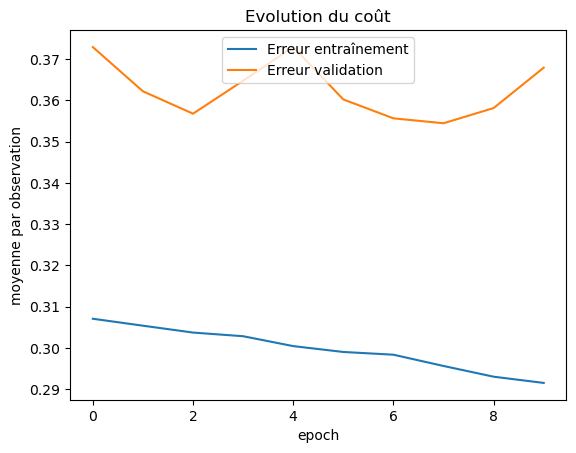

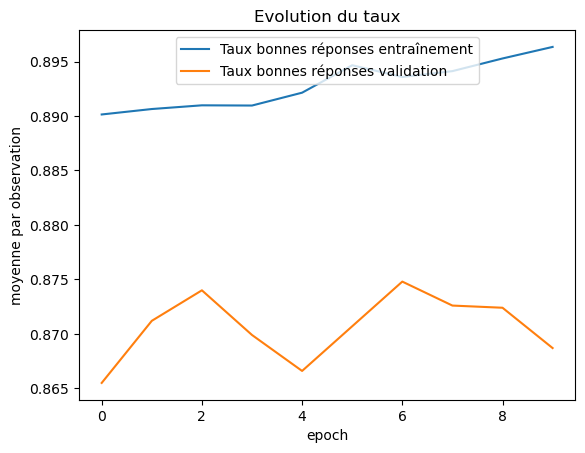

In [2]:
entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10)

-------- > epoch 1:  coût moyen entraînement = 0.2709595263004303
-------- > epoch 1:  taux moyen entraînement = 0.9039209485054016
-------- > epoch 1:  coût moyen validation = 0.3444693088531494
-------- > epoch 1:  taux moyen validation = 0.8755000829696655
-------- > epoch 2:  coût moyen entraînement = 0.2706131339073181
-------- > epoch 2:  taux moyen entraînement = 0.9042606949806213
-------- > epoch 2:  coût moyen validation = 0.34391987323760986
-------- > epoch 2:  taux moyen validation = 0.8754000067710876
-------- > epoch 3:  coût moyen entraînement = 0.2704421281814575
-------- > epoch 3:  taux moyen entraînement = 0.9042604565620422
-------- > epoch 3:  coût moyen validation = 0.3449716567993164
-------- > epoch 3:  taux moyen validation = 0.8770000338554382
-------- > epoch 4:  coût moyen entraînement = 0.2701658308506012
-------- > epoch 4:  taux moyen entraînement = 0.9041807651519775
-------- > epoch 4:  coût moyen validation = 0.34533101320266724
-------- > epoch 4:  t

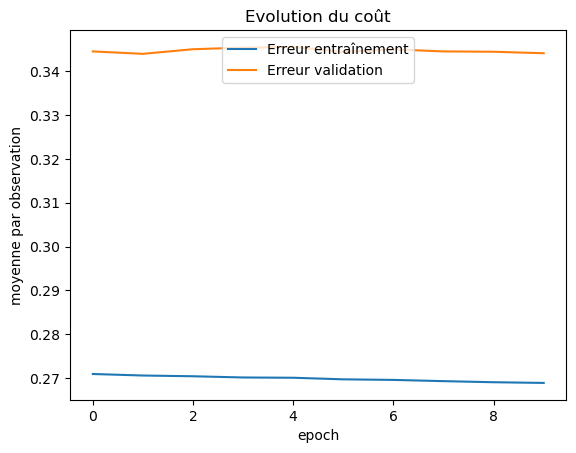

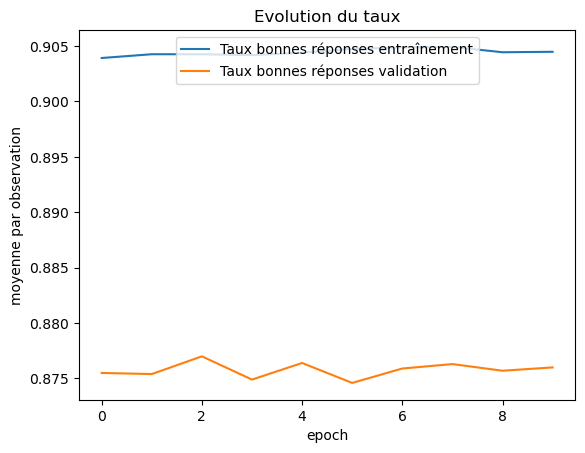

In [4]:
optimiseur = optim.SGD(modele.parameters(), lr=0.005)
entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10)

In [5]:
CHEMIN = './MNISTSimple10.pth'
torch.save(modele.state_dict(), CHEMIN)

C:\Users\vango\AppData\Local\Temp\ipykernel_16868\3595662355.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modele.load_state_dict(torch.load(CHEMIN))


-------- > epoch 1:  coût moyen entraînement = 0.2687199115753174
-------- > epoch 1:  taux moyen entraînement = 0.9047011137008667
-------- > epoch 1:  coût moyen validation = 0.34554362297058105
-------- > epoch 1:  taux moyen validation = 0.8751999139785767
-------- > epoch 2:  coût moyen entraînement = 0.2684316635131836
-------- > epoch 2:  taux moyen entraînement = 0.9050611257553101
-------- > epoch 2:  coût moyen validation = 0.34480753540992737
-------- > epoch 2:  taux moyen validation = 0.8752000331878662
-------- > epoch 3:  coût moyen entraînement = 0.26833611726760864
-------- > epoch 3:  taux moyen entraînement = 0.9051607251167297
-------- > epoch 3:  coût moyen validation = 0.3449094295501709
-------- > epoch 3:  taux moyen validation = 0.8759002089500427
-------- > epoch 4:  coût moyen entraînement = 0.26817265152931213
-------- > epoch 4:  taux moyen entraînement = 0.9048810005187988
-------- > epoch 4:  coût moyen validation = 0.34455785155296326
-------- > epoch 4:

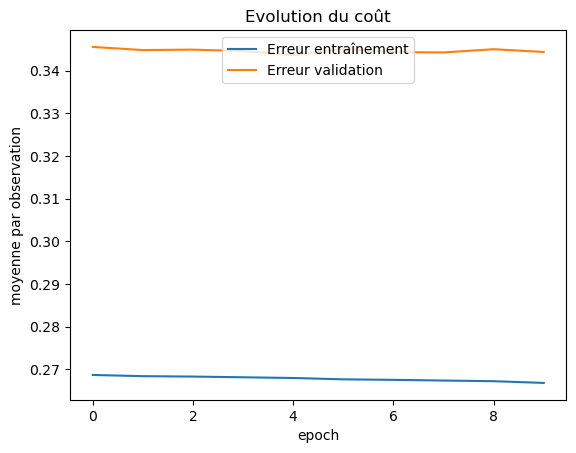

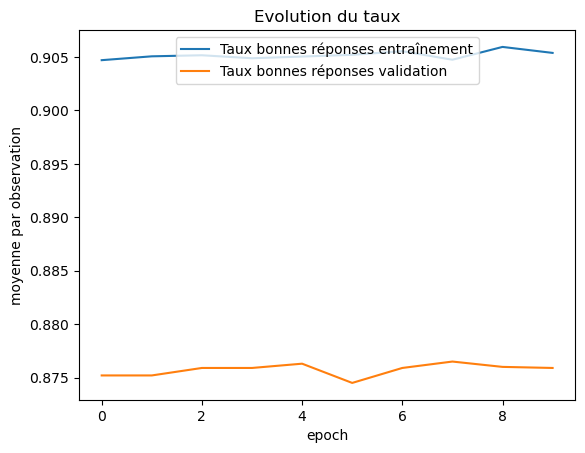

In [6]:
modele.load_state_dict(torch.load(CHEMIN))
entrainer(modele, dl_ent, dl_valid, optimiseur, nb_epochs=10)

In [7]:
ds_test = TensorDataset(donnees_test_X,donnees_test_Y)
dl_test = DataLoader(ds_test, batch_size=100)
with torch.no_grad():
    cout_test = sum(fonction_cout(modele(lot_test_X), lot_test_Y) for lot_test_X, lot_test_Y in dl_test)
    taux_bons_test = sum(taux_bonnes_predictions(modele(lot_test_X), lot_test_Y) for lot_test_X, lot_test_Y in dl_test)
cout_moyen_test = cout_test/len(dl_test)
taux_moyen_test = taux_bons_test/len(dl_test)
print(f'-------- > coût moyen test = {cout_moyen_test}')
print(f'-------- > taux moyen test = {taux_moyen_test}')

NameError: name 'TensorDataset' is not defined